In [1]:
import os 
import pandas as pd
import numpy as np

directory = os.getcwd()

cwd = directory.replace('Strat_7', '\module_1')
os.chdir(cwd)

import Preprocessing_functions as pf 
import calculateMaxDD 
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\module_1'

In [4]:
ticker = 'SPY'

df = pf.downlaod_symbol_data(ticker, period= '120mo')
try:
    df = df.drop(columns=['Stock Splits', 'Dividends', 'Capital Gains'])
except KeyError:
    print("Columns not available (see above line of code)")
    
df = pf.create_momentum_feat(df, symbol=ticker) ### need to inspect in more detail how the create momemntum features work and the shift in this case
df = pf.technical_indicators(df,MA_DIVERGENCE=True)
df = pf.format_idx_date(df)

df['overnight_pct'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

df = df.dropna()

df.head()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,MACD,diff_Close_8,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,overnight_pct
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-18,165.67,165.73,164.40,164.72,102343000,0.766584,0.573429,-0.036217,0.802510,-0.194647,...,0.753237,3.90250,2.7120,-2.8998,-6.1633,-8.15960,-6.80230,-3.2635,-5.25980,0.001693
2016-02-19,163.93,164.79,163.31,164.64,114793000,0.378210,-0.433112,-0.524614,0.898113,-0.814402,...,0.834201,3.11750,2.5232,-2.7206,-6.2458,-8.18135,-5.83810,-3.5252,-5.46075,-0.004796
2016-02-22,166.24,167.17,166.17,167.02,103640300,0.042108,-0.469201,-0.559432,0.598193,-0.511524,...,1.009859,4.49500,4.8056,-0.1528,-3.9334,-5.75860,-4.64780,-3.7806,-5.60580,0.009718
2016-02-23,166.35,166.63,164.79,164.91,111455300,0.937782,0.865645,-0.168320,1.104243,-0.072820,...,0.946818,1.63000,2.5412,-2.0602,-6.0889,-7.81180,-3.69020,-4.0287,-5.75160,-0.004011
2016-02-24,163.46,165.95,162.34,165.67,150812200,0.685183,-1.352013,-1.523308,2.175354,-2.051250,...,0.918469,1.28125,3.1248,-1.1038,-5.3521,-6.98720,-2.38505,-4.2483,-5.88340,-0.008793


In [5]:
print('Start date of dataframe: ', df.index.min())
print('End date of dataframe: ', df.index.max())

Start date of dataframe:  2016-02-18 00:00:00
End date of dataframe:  2025-03-05 00:00:00


In [6]:
y = df.pop('overnight_pct')
X = df.copy()
X = X.drop(columns= ['Open', 'High', 'Low', 'Close',])

# Split data into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [27]:
X.columns

Index(['Volume', 'open_low', 'open_close', 'open_high', 'high_low',
       'low_close', 'high_close', 'gap', 'SPY_mom1', 'SPY_mom2', 'SPY_mom3',
       'SPY_mom4', 'SPY_mom5', 'SPY_mom10', 'SPY_mom15', 'SPY_mom20',
       'SPY_mom60', 'SPY_mom120', 'SPY_mom180', 'SPY_mom240', 'ATR', 'MACD',
       'diff_Close_8', 'diff_Close_25', 'diff_Close_50', 'diff_Close_100',
       'diff_Close_200', 'diff_8_50', 'diff_50_100', 'diff_50_200'],
      dtype='object')

In [29]:
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\Strat_7\\models'

In [ ]:
model_columns = pd.DataFrame(X.columns, columns=['features'])

model_columns.to_csv(f'model_features/{ticker}_features_{len(X.columns)}.csv', index = False)


OSError: Cannot save file into a non-existent directory: 'model_features'

In [ ]:
# Define Random Forest model
rf = RandomForestRegressor(random_state=42)

# Grid Search for best hyperparameters
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

In [ ]:
# Cross-validation with 10-folds
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores)
print(f"10-Fold CV RMSE: {rmse_cv.mean():.4f} ± {rmse_cv.std():.4f}")

In [ ]:
# Evaluate on validation set
y_val_pred = best_rf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse_val:.4f}")

In [ ]:
X_val.head()

In [ ]:
# Final evaluation on test set
y_test_pred = best_rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_test:.4f}")

In [12]:
os.chdir(cwd.replace('module_1', 'Strat_7\models'))

In [32]:
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\module_1'

In [ ]:
# Save the best model
os.chdir(cwd.replace('module_1', 'Strat_7\models'))
joblib.dump(best_rf, f"{ticker}_overnight_regression_random_forest.pkl")
print(f"Model saved as {ticker}_overnight_regression_random_forest.pkl")


In [33]:
os.chdir(cwd.replace('module_1', 'Strat_7\model_features'))
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\Strat_7\\model_features'

In [ ]:
model_columns = pd.DataFrame(X.columns, columns=['features'])

model_columns.to_csv(f'{ticker}_features_{len(X.columns)}.csv', index=False)

os.listdir()

['SPY_features_30.csv']


# Save the best model
joblib.dump(best_rf, "best_random_forest.pkl")
print("Model saved as best_random_forest.pkl")

# Load the model for future use
loaded_model = joblib.load("best_random_forest.pkl")
y_loaded_pred = loaded_model.predict(X_test)

#### BACKTESTING

In [ ]:

df1 = pf.downlaod_symbol_data(ticker, period= '360mo')
try:
    df1 = df1.drop(columns=['Stock Splits', 'Dividends', 'Capital Gains'])
except KeyError:
    print("Columns not available (see above line of code)")
    
df1 = pf.create_momentum_feat(df1, symbol=ticker) ### need to inspect in more detail how the create momemntum features work and the shift in this case
df1 = pf.technical_indicators(df1,MA_DIVERGENCE=True)
df1 = pf.format_idx_date(df1)

df1 = df1.dropna()

model_start_date = df.index.min()

df1 = df1[df1.index < model_start_date]

df1.head()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,ATR,MACD,diff_Close_8,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200
Date,,,,,,,,,,,,,,,,,,,,,
1996-02-14,39.75,39.88,39.41,39.43,431400,0.855346,0.805031,-0.327044,1.178536,-0.050749,...,0.396464,0.144964,0.07500,1.6036,2.0336,3.0799,4.88370,1.95860,1.0463,2.85010
1996-02-15,39.35,39.61,39.14,39.19,889500,0.533672,0.406607,-0.660737,1.186569,-0.127747,...,0.401716,0.084721,-0.24375,1.2464,1.7522,2.7958,4.60215,1.99595,1.0436,2.84995
1996-02-16,39.11,39.21,38.91,39.03,606100,0.511378,0.204551,-0.255689,0.765111,-0.308404,...,0.394451,0.026530,-0.41625,0.9732,1.5556,2.5932,4.40130,1.97185,1.0376,2.84570
1996-02-20,38.73,38.84,38.39,38.64,492300,0.877872,0.232378,-0.284018,1.158599,-0.651211,...,0.411990,-0.042063,-0.74250,0.4828,1.1330,2.1642,3.97225,1.87550,1.0312,2.83925
1996-02-21,38.72,39.15,38.72,39.12,434000,0.000000,-1.033058,-1.110537,1.098340,-1.033058,...,0.418991,-0.057962,-0.20625,0.8608,1.5732,2.6030,4.41190,1.77945,1.0298,2.83870


In [8]:
X.columns

Index(['Volume', 'open_low', 'open_close', 'open_high', 'high_low',
       'low_close', 'high_close', 'gap', 'SPY_mom1', 'SPY_mom2', 'SPY_mom3',
       'SPY_mom4', 'SPY_mom5', 'SPY_mom10', 'SPY_mom15', 'SPY_mom20',
       'SPY_mom60', 'SPY_mom120', 'SPY_mom180', 'SPY_mom240', 'ATR', 'MACD',
       'diff_Close_8', 'diff_Close_25', 'diff_Close_50', 'diff_Close_100',
       'diff_Close_200', 'diff_8_50', 'diff_50_100', 'diff_50_200'],
      dtype='object')

In [9]:
df2 = df1[X.columns]

df2.head()

,Volume,open_low,open_close,open_high,high_low,low_close,high_close,gap,SPY_mom1,SPY_mom2,...,ATR,MACD,diff_Close_8,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200
Date,,,,,,,,,,,,,,,,,,,,,
1996-02-14,431400,0.855346,0.805031,-0.327044,1.178536,-0.050749,-1.128385,-0.075415,-0.88,-1.08,...,0.396464,0.144964,0.07500,1.6036,2.0336,3.0799,4.88370,1.95860,1.0463,2.85010
1996-02-15,889500,0.533672,0.406607,-0.660737,1.186569,-0.127747,-1.060338,-0.202891,-0.61,-1.48,...,0.401716,0.084721,-0.24375,1.2464,1.7522,2.7958,4.60215,1.99595,1.0436,2.84995
1996-02-16,606100,0.511378,0.204551,-0.255689,0.765111,-0.308404,-0.459067,-0.204134,-0.41,-1.01,...,0.394451,0.026530,-0.41625,0.9732,1.5556,2.5932,4.40130,1.97185,1.0376,2.84570
1996-02-20,492300,0.877872,0.232378,-0.284018,1.158599,-0.651211,-0.514933,-0.768640,-1.00,-1.40,...,0.411990,-0.042063,-0.74250,0.4828,1.1330,2.1642,3.97225,1.87550,1.0312,2.83925
1996-02-21,434000,0.000000,-1.033058,-1.110537,1.098340,-1.033058,-0.076628,0.207039,1.24,0.23,...,0.418991,-0.057962,-0.20625,0.8608,1.5732,2.6030,4.41190,1.77945,1.0298,2.83870


In [ ]:
os.chdir(cwd.replace('module_1', 'Strat_7\models'))
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\module_1'

In [13]:
best_rf = joblib.load(f"{ticker}_overnight_regression_random_forest.pkl")

In [14]:
df1['predictions'] = best_rf.predict(df2)
df1['overnight_pct'] = (df1['Open'] - df1['Close'].shift(1)) / df1['Close'].shift(1)
df1['action'] = np.where(df1['predictions'] > 0, 'BUY', 'SELL')
df1.head()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,diff_Close_25,diff_Close_50,diff_Close_100,diff_Close_200,diff_8_50,diff_50_100,diff_50_200,predictions,overnight_pct,action
Date,,,,,,,,,,,,,,,,,,,,,
1996-02-14,39.75,39.88,39.41,39.43,431400,0.855346,0.805031,-0.327044,1.178536,-0.050749,...,1.6036,2.0336,3.0799,4.88370,1.95860,1.0463,2.85010,-0.000749,NaN,SELL
1996-02-15,39.35,39.61,39.14,39.19,889500,0.533672,0.406607,-0.660737,1.186569,-0.127747,...,1.2464,1.7522,2.7958,4.60215,1.99595,1.0436,2.84995,-0.002040,-0.002029,SELL
1996-02-16,39.11,39.21,38.91,39.03,606100,0.511378,0.204551,-0.255689,0.765111,-0.308404,...,0.9732,1.5556,2.5932,4.40130,1.97185,1.0376,2.84570,-0.002047,-0.002041,SELL
1996-02-20,38.73,38.84,38.39,38.64,492300,0.877872,0.232378,-0.284018,1.158599,-0.651211,...,0.4828,1.1330,2.1642,3.97225,1.87550,1.0312,2.83925,-0.007669,-0.007686,SELL
1996-02-21,38.72,39.15,38.72,39.12,434000,0.000000,-1.033058,-1.110537,1.098340,-1.033058,...,0.8608,1.5732,2.6030,4.41190,1.77945,1.0298,2.83870,0.002069,0.002070,BUY


In [23]:
df1 = df1.dropna()
df1['prev_close'] = df1['Close'].shift()
df1['tom_open'] = df1['Open'].shift(-1)

cols = df1.columns
cols = [i for i in cols if i not in X.columns]

df1 = df1[cols]

df1.head()

,Open,High,Low,Close,predictions,overnight_pct,action,prev_close,tom_open,error,return,cum_ret
Date,,,,,,,,,,,,
1996-02-20,38.73,38.84,38.39,38.64,-0.007669,-0.007686,SELL,NaN,38.72,0.000018,0.007686,0.011757
1996-02-21,38.72,39.15,38.72,39.12,0.002069,0.002070,BUY,38.64,39.34,-0.000002,0.002070,0.013827
1996-02-22,39.34,39.86,39.31,39.74,0.005636,0.005624,BUY,39.12,39.97,0.000012,0.005624,0.019451
1996-02-23,39.97,40.03,39.26,39.63,0.005726,0.005788,BUY,39.74,39.52,-0.000061,0.005788,0.025238
1996-02-26,39.52,39.60,39.05,39.07,-0.002798,-0.002776,SELL,39.63,39.16,-0.000023,0.002776,0.028014


Text(0, 0.5, 'Pct Difference')

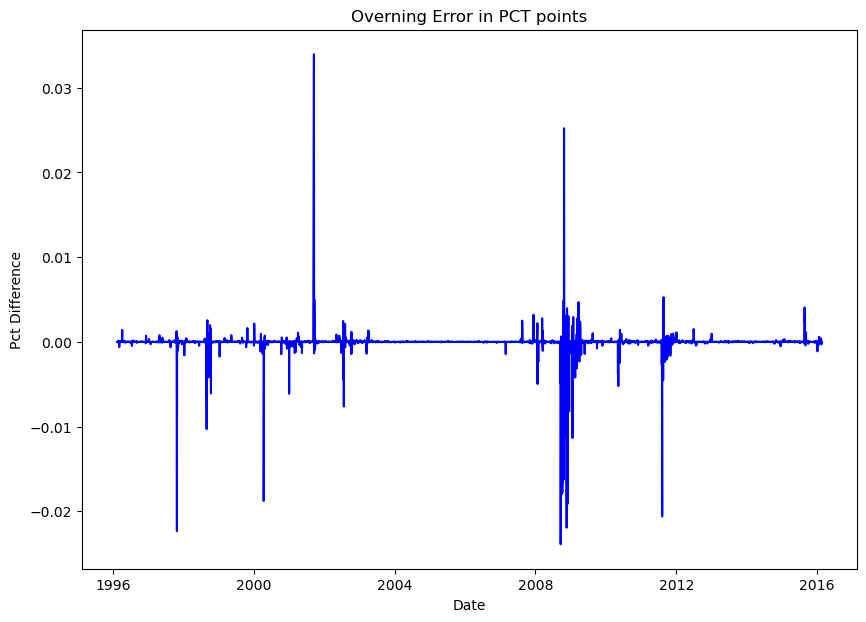

In [16]:
import matplotlib.pyplot as plt 

df1['error'] = df1['predictions'] - df1['overnight_pct']

plt.figure(figsize=[10,7])
plt.plot(df1.index, df1['error'] , color = 'b')
plt.title('Overning Error in PCT points')
plt.xlabel('Date')
plt.ylabel('Pct Difference')

In [ ]:
df1.head()

In [17]:
df1['return'] = np.where(df1['action'] == 'SELL', df1['overnight_pct'] * (-1), df1['overnight_pct'])
df1.head()

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,diff_8_50,diff_50_100,diff_50_200,predictions,overnight_pct,action,prev_close,tom_open,error,return
Date,,,,,,,,,,,,,,,,,,,,,
1996-02-15,39.35,39.61,39.14,39.19,889500,0.533672,0.406607,-0.660737,1.186569,-0.127747,...,1.99595,1.0436,2.84995,-0.002040,-0.002029,SELL,NaN,39.11,-0.000011,0.002029
1996-02-16,39.11,39.21,38.91,39.03,606100,0.511378,0.204551,-0.255689,0.765111,-0.308404,...,1.97185,1.0376,2.84570,-0.002047,-0.002041,SELL,39.19,38.73,-0.000005,0.002041
1996-02-20,38.73,38.84,38.39,38.64,492300,0.877872,0.232378,-0.284018,1.158599,-0.651211,...,1.87550,1.0312,2.83925,-0.007669,-0.007686,SELL,39.03,38.72,0.000018,0.007686
1996-02-21,38.72,39.15,38.72,39.12,434000,0.000000,-1.033058,-1.110537,1.098340,-1.033058,...,1.77945,1.0298,2.83870,0.002069,0.002070,BUY,38.64,39.34,-0.000002,0.002070
1996-02-22,39.34,39.86,39.31,39.74,721400,0.076258,-1.016777,-1.321810,1.379829,-1.093869,...,1.75295,1.0307,2.84410,0.005636,0.005624,BUY,39.12,39.97,0.000012,0.005624


Text(0, 0.5, 'Cummulative Return PCT')

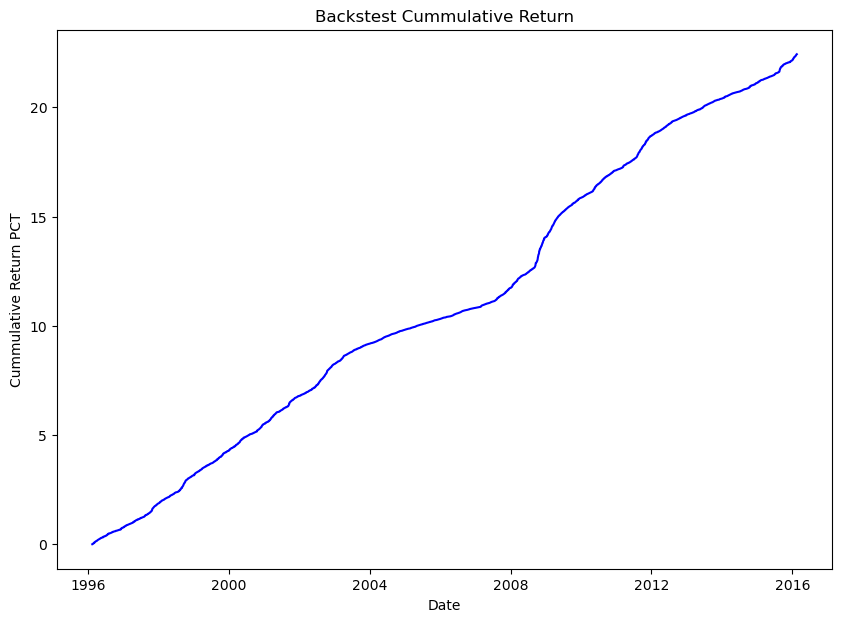

In [ ]:
df1['cum_ret'] = df1['return'].cumsum()

plt.figure(figsize=[10,7])
plt.plot(df1.index, df1['cum_ret'] , color = 'b')
plt.title('Backtest Cummulative Return PCT')
plt.xlabel('Date')
plt.ylabel('Cummulative Return PCT')

In [20]:
df1[df1['return'] < 0]

,Open,High,Low,Close,Volume,open_low,open_close,open_high,high_low,low_close,...,diff_50_100,diff_50_200,predictions,overnight_pct,action,prev_close,tom_open,error,return,cum_ret
Date,,,,,,,,,,,,,,,,,,,,,
1998-08-31,64.97,65.14,59.49,60.12,22563100,8.434662,7.464984,-0.261659,8.673626,-1.059002,...,0.4442,3.90225,-0.006751,0.003553,SELL,64.74,60.16,-0.010303,-0.003553,2.580512
1998-09-01,60.16,62.98,58.63,62.66,24748500,2.543218,-4.155585,-4.687500,6.906955,-6.873614,...,0.3797,3.74155,-0.000678,0.000665,SELL,60.12,62.51,-0.001343,-0.000665,2.579847
2001-09-19,67.42,67.68,63.83,66.02,42771800,5.324829,2.076535,-0.385642,5.688534,-3.430989,...,-2.5437,-4.25505,-0.000756,0.000594,SELL,67.38,65.02,-0.001350,-0.000594,6.416968
2009-01-09,67.63,67.75,63.33,66.10,330953600,6.358125,2.262310,-0.177436,6.523985,-4.373914,...,-8.6256,-20.14340,-0.000051,0.001333,SELL,67.54,65.91,-0.001384,-0.001333,14.095077


In [24]:
df1

,Open,High,Low,Close,predictions,overnight_pct,action,prev_close,tom_open,error,return,cum_ret
Date,,,,,,,,,,,,
1996-02-20,38.73,38.84,38.39,38.64,-0.007669,-0.007686,SELL,NaN,38.72,0.000018,0.007686,0.011757
1996-02-21,38.72,39.15,38.72,39.12,0.002069,0.002070,BUY,38.64,39.34,-0.000002,0.002070,0.013827
1996-02-22,39.34,39.86,39.31,39.74,0.005636,0.005624,BUY,39.12,39.97,0.000012,0.005624,0.019451
1996-02-23,39.97,40.03,39.26,39.63,0.005726,0.005788,BUY,39.74,39.52,-0.000061,0.005788,0.025238
1996-02-26,39.52,39.60,39.05,39.07,-0.002798,-0.002776,SELL,39.63,39.16,-0.000023,0.002776,0.028014
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-08,159.30,159.60,156.75,159.00,-0.011461,-0.011603,SELL,161.17,157.23,0.000141,0.011603,22.370068
2016-02-09,157.23,160.30,157.09,159.00,-0.011172,-0.011132,SELL,159.00,159.84,-0.000040,0.011132,22.381200
2016-02-10,159.84,161.50,158.74,158.87,0.005268,0.005283,BUY,159.00,156.35,-0.000015,0.005283,22.386483


In [26]:

#####   MAX DRAWDOWN
#from calculateMaxDD import calculateMaxDD

cum_ret = np.cumprod(1+ df1['return']) - 1
maxDrawdown, maxDrawdownDuration, startDrawdownDay=calculateMaxDD.calculateMaxDD(cum_ret.values)

#####   SHARPE RATIO
sharpe_ratio = round(np.sqrt(252) * np.mean(df1['return']) / np.std(df1['return']),2)

#####   AVG YEARLY RETURN AND STD
mean_ret = df1['return'].mean() * 252
std = df1['return'].std()*np.sqrt(252)

print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Maximum Drawdown: {round(maxDrawdown,4)}')
print(f'Max Drawdown Duration: {maxDrawdownDuration} days' )
print(f'Start day Drawdown: {startDrawdownDay}')
print(f"Average Yearly Return: {round(mean_ret*100, 2)} %")

Sharpe Ratio: 13.67
Maximum Drawdown: -0.0042
Max Drawdown Duration: 3.0 days
Start day Drawdown: 640
Average Yearly Return: 112.25 %


In [36]:
df1

,Open,High,Low,Close,predictions,overnight_pct,action,prev_close,tom_open,error,return,cum_ret
Date,,,,,,,,,,,,
1996-02-20,38.73,38.84,38.39,38.64,-0.007669,-0.007686,SELL,NaN,38.72,0.000018,0.007686,0.011757
1996-02-21,38.72,39.15,38.72,39.12,0.002069,0.002070,BUY,38.64,39.34,-0.000002,0.002070,0.013827
1996-02-22,39.34,39.86,39.31,39.74,0.005636,0.005624,BUY,39.12,39.97,0.000012,0.005624,0.019451
1996-02-23,39.97,40.03,39.26,39.63,0.005726,0.005788,BUY,39.74,39.52,-0.000061,0.005788,0.025238
1996-02-26,39.52,39.60,39.05,39.07,-0.002798,-0.002776,SELL,39.63,39.16,-0.000023,0.002776,0.028014
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-08,159.30,159.60,156.75,159.00,-0.011461,-0.011603,SELL,161.17,157.23,0.000141,0.011603,22.370068
2016-02-09,157.23,160.30,157.09,159.00,-0.011172,-0.011132,SELL,159.00,159.84,-0.000040,0.011132,22.381200
2016-02-10,159.84,161.50,158.74,158.87,0.005268,0.005283,BUY,159.00,156.35,-0.000015,0.005283,22.386483


In [43]:
rets = df1[['return']]
rets.to_csv(directory + '\strat_returns' + f'\{ticker}.csv')

In [40]:
directory

'c:\\Users\\User\\Documents\\ATS_Development\\Strat_7'